In [1]:
%load_ext autoreload
%autoreload 2

In [94]:
import os
import re
import glob
import torch
import pickle
import numpy as np
import pandas as pd
import scanpy as sc
import pertpy as pt
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold

In [3]:
print(ad.__version__)
print(sc.__version__)
print(pt.__version__)

0.10.8
1.10.3
0.9.4


In [4]:
output_dir = "/lustre/groups/ml01/workspace/ot_perturbation/data/norman_soren"
os.makedirs(output_dir, exist_ok=True)

In [5]:
adata = pt.dt.norman_2019()

In [167]:
adata.shape

(111255, 2000)

In [6]:
##### DEG calculation

In [7]:
def rank_genes_groups_by_cov(
    adata,
    groupby,
    control_group,
    covariate,
    n_genes=50,
    rankby_abs=True,
    key_added="rank_genes_groups_cov",
    return_dict=False,
):
    gene_dict = {}
    cov_categories = adata.obs[covariate].unique()
    for cov_cat in cov_categories:
        # name of the control group in the groupby obs column
        control_group_cov = control_group  # "_".join([cov_cat, control_group])
        # subset adata to cells belonging to a covariate category
        adata_cov = adata[adata.obs[covariate] == cov_cat]
        # compute DEGs
        sc.tl.rank_genes_groups(
            adata_cov,
            groupby=groupby,
            reference=control_group_cov,
            rankby_abs=rankby_abs,
            n_genes=n_genes,
            use_raw=False,
        )
        # add entries to dictionary of gene sets
        de_genes = pd.DataFrame(adata_cov.uns["rank_genes_groups"]["names"])
        for group in de_genes:
            gene_dict[group] = de_genes[group].tolist()
    adata.uns[key_added] = gene_dict
    if return_dict:
        return gene_dict


def get_DE_genes(adata):
    adata.obs.loc[:, "control"] = adata.obs.condition.apply(lambda x: 1 if x == "control" else 0)
    adata.obs = adata.obs.astype("category")
    rank_genes_groups_by_cov(
        adata,
        groupby="condition",
        covariate="cell_line",
        control_group="ctrl",
        n_genes=50,
        key_added="rank_genes_groups_cov_all",
    )
    return adata

In [8]:
# Specify the folder path
folder_path = '/lustre/groups/ml01/workspace/ot_perturbation/pert_embeddings/norman/norman/'

# Use glob to get all .pt files in the folder
pt_files = glob.glob(folder_path + '*.pt')
print(f"Found {len(pt_files)} files.")

Found 105 files.


In [9]:
genes_pert = {}

for path in pt_files:
    split_path = path.split('_')
    gene = split_path[3]
    loaded = torch.load(path)
    genes_pert[gene] = loaded['mean_representations'][36]

/tmp/ipykernel_1265463/602684097.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded = torch.load(path)


In [154]:
loaded

{'label': 'from_ENSG00000184697_entry_P56747_gene_names_CLDN6_UNQ757PRO1488_3',
 'mean_representations': {36: tensor([ 0.0870,  0.0062, -0.0365,  ...,  0.0035, -0.1908, -0.0905])}}

In [10]:
genes_pert

{'ENSG00000125931': tensor([ 0.0034, -0.0302,  0.0348,  ...,  0.0210, -0.0944, -0.0090]),
 'ENSG00000126804': tensor([-0.0612, -0.0331,  0.0230,  ...,  0.0482, -0.0650,  0.0217]),
 'ENSG00000111276': tensor([-0.0200, -0.0187,  0.0027,  ...,  0.0992, -0.0537,  0.0292]),
 'ENSG00000100030': tensor([-0.0242, -0.0016,  0.0313,  ..., -0.0424, -0.1246, -0.0647]),
 'ENSG00000139219': tensor([-0.1129, -0.1369,  0.0984,  ..., -0.0537, -0.0267, -0.0023]),
 'ENSG00000129757': tensor([-0.0498, -0.0416,  0.0071,  ...,  0.0935, -0.0331, -0.0364]),
 'ENSG00000183770': tensor([-0.0095,  0.0054,  0.0034,  ...,  0.0340, -0.1072,  0.0280]),
 'ENSG00000130176': tensor([ 0.0096,  0.0630,  0.0086,  ...,  0.0066, -0.1048, -0.0202]),
 'ENSG00000143995': tensor([ 0.0400, -0.0240,  0.0045,  ..., -0.0066, -0.1333,  0.0667]),
 'ENSG00000245848': tensor([ 0.0197,  0.0017,  0.0418,  ...,  0.0380, -0.0831, -0.0080]),
 'ENSG00000173207': tensor([ 0.0625, -0.0676, -0.0292,  ...,  0.0139, -0.1786,  0.0241]),
 'ENSG0000

In [156]:
adata.obs['perturbation_name']

index
AAACCTGAGAAGAAGC-1          control
AAACCTGAGGCATGTG-1          TSC22D1
AAACCTGAGGCCCTTG-1      KLF1+MAP2K6
AAACCTGCACGAAGCA-1          control
AAACCTGCAGACGTAG-1    CEBPE+RUNX1T1
                          ...      
TTTGTCATCAGTACGT-8            FOXA3
TTTGTCATCCACTCCA-8            CELF2
TTTGTCATCCCAACGG-8           BCORL1
TTTGTCATCCTCCTAG-8    PTPN12+ZBTB10
TTTGTCATCTGGCGAC-8           MAP4K3
Name: perturbation_name, Length: 111255, dtype: category
Categories (237, object): ['AHR', 'AHR+FEV', 'AHR+KLF1', 'ARID1A', ..., 'ZBTB25', 'ZC3HAV1', 'ZNF318', 'control']

In [11]:
adata.obs[['gene_1', 'gene_2']] = adata.obs['perturbation_name'].str.split('+', expand=True)

In [12]:
display(adata.obs.iloc[:5])

,guide_identity,read_count,UMI_count,coverage,gemgroup,good_coverage,number_of_cells,guide_AHR,guide_ARID1A,guide_ARRDC3,...,total_counts,total_counts_mt,pct_counts_mt,leiden,perturbation_name,perturbation_type,perturbation_value,perturbation_unit,gene_1,gene_2
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGAAGAAGC-1,NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0,1252,67,18.686567,1,True,2,0,0,0,...,19413.0,1327.0,6.835625,10,control,genetic,NaN,NaN,control,None
AAACCTGAGGCATGTG-1,TSC22D1_NegCtrl0__TSC22D1_NegCtrl0,2151,104,20.682692,1,True,1,0,0,0,...,13474.0,962.0,7.139676,3,TSC22D1,genetic,NaN,NaN,TSC22D1,None
AAACCTGAGGCCCTTG-1,KLF1_MAP2K6__KLF1_MAP2K6,1037,59,17.576271,1,True,1,0,0,0,...,23228.0,1548.0,6.664371,7,KLF1+MAP2K6,genetic,NaN,NaN,KLF1,MAP2K6
AAACCTGCACGAAGCA-1,NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0,958,39,24.564103,1,True,1,0,0,0,...,6842.0,523.0,7.643963,2,control,genetic,NaN,NaN,control,None
AAACCTGCAGACGTAG-1,CEBPE_RUNX1T1__CEBPE_RUNX1T1,244,14,17.428571,1,True,1,0,0,0,...,9130.0,893.0,9.780942,10,CEBPE+RUNX1T1,genetic,NaN,NaN,CEBPE,RUNX1T1


In [13]:
adata.obs['gene_2'].fillna('control', inplace=True)

/tmp/ipykernel_1265463/4207078196.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  adata.obs['gene_2'].fillna('control', inplace=True)


In [14]:
display(adata.obs.iloc[:5])

,guide_identity,read_count,UMI_count,coverage,gemgroup,good_coverage,number_of_cells,guide_AHR,guide_ARID1A,guide_ARRDC3,...,total_counts,total_counts_mt,pct_counts_mt,leiden,perturbation_name,perturbation_type,perturbation_value,perturbation_unit,gene_1,gene_2
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGAAGAAGC-1,NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0,1252,67,18.686567,1,True,2,0,0,0,...,19413.0,1327.0,6.835625,10,control,genetic,NaN,NaN,control,control
AAACCTGAGGCATGTG-1,TSC22D1_NegCtrl0__TSC22D1_NegCtrl0,2151,104,20.682692,1,True,1,0,0,0,...,13474.0,962.0,7.139676,3,TSC22D1,genetic,NaN,NaN,TSC22D1,control
AAACCTGAGGCCCTTG-1,KLF1_MAP2K6__KLF1_MAP2K6,1037,59,17.576271,1,True,1,0,0,0,...,23228.0,1548.0,6.664371,7,KLF1+MAP2K6,genetic,NaN,NaN,KLF1,MAP2K6
AAACCTGCACGAAGCA-1,NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0,958,39,24.564103,1,True,1,0,0,0,...,6842.0,523.0,7.643963,2,control,genetic,NaN,NaN,control,control
AAACCTGCAGACGTAG-1,CEBPE_RUNX1T1__CEBPE_RUNX1T1,244,14,17.428571,1,True,1,0,0,0,...,9130.0,893.0,9.780942,10,CEBPE+RUNX1T1,genetic,NaN,NaN,CEBPE,RUNX1T1


In [15]:
embedding_dim = genes_pert['ENSG00000125931'].shape[0]
# mapping maps gene_symbol to ensemble id
mapping = pd.DataFrame()
mapping.index = adata.var.index
mapping.loc[:, 'index'] = adata.var['index']
display(mapping.iloc[:3])

,index
gene_symbols,
RP11-34P13.3,ENSG00000243485
RP11-34P13.7,ENSG00000238009
FO538757.2,ENSG00000279457


In [168]:
for path in pt_files:
    if 'KIAA1804' in path:
        print(path)
        break
for path in pt_files:
    if 'C19orf26' in path:
        print(path)
        break
for path in pt_files:
    if 'C3orf72' in path:
        print(path)
        break

/lustre/groups/ml01/workspace/ot_perturbation/pert_embeddings/norman/norman/from_ENSG00000143674_entry_Q5TCX8_gene_names_MAP3K21_KIAA1804_MLK4_102.pt
/lustre/groups/ml01/workspace/ot_perturbation/pert_embeddings/norman/norman/from_ENSG00000099625_entry_Q8N350_gene_names_CBARP_C19orf26_101.pt
/lustre/groups/ml01/workspace/ot_perturbation/pert_embeddings/norman/norman/from_ENSG00000206262_entry_Q6ZUU3_gene_names_FOXL2NB_C3orf72_103.pt


In [169]:
# manually setting names for missing perturbations?
mapping.loc['KIAA1804'] = 'ENSG00000143674'
mapping.loc['C19orf26'] = 'ENSG00000099625'
mapping.loc['C3orf72'] = 'ENSG00000206262'

In [19]:
perturbed_genes = np.unique(
    adata.obs.loc[:, 'gene_1'].values.tolist() + \
    adata.obs.loc[:, 'gene_2'].values.tolist()
)

gene_to_embedding = {}

for gene in perturbed_genes:
    gene_to_embedding[gene] = genes_pert[mapping.loc['AHR', "index"]]
gene_to_embedding["control"] = np.zeros_like(gene_to_embedding["control"])
adata.uns['ems2'] = gene_to_embedding

In [20]:
def column_to_barplot(adata, column, figsize=(10, 10), fontsize=8):
    fig, ax = plt.subplots(1,1, figsize=figsize)
    _tmp = adata.obs[column].value_counts().to_frame()
    sns.barplot(
        data=_tmp,
        ax=ax,
        x="count",
        y=column,
        order=_tmp.sort_values(by="count", ascending=False).index,
    )
    plt.yticks(fontsize=fontsize)
    plt.show()

In [158]:
adata.obs.perturbation_name.unique()

['control', 'TSC22D1', 'KLF1+MAP2K6', 'CEBPE+RUNX1T1', 'MAML2', ..., 'CDKN1A+CDKN1C', 'PLK4+STIL', 'ELMSAN1+ZBTB10', 'CDKN1C', 'C3orf72+FOXL2']
Length: 237
Categories (237, object): ['AHR', 'AHR+FEV', 'AHR+KLF1', 'ARID1A', ..., 'ZBTB25', 'ZC3HAV1', 'ZNF318', 'control']

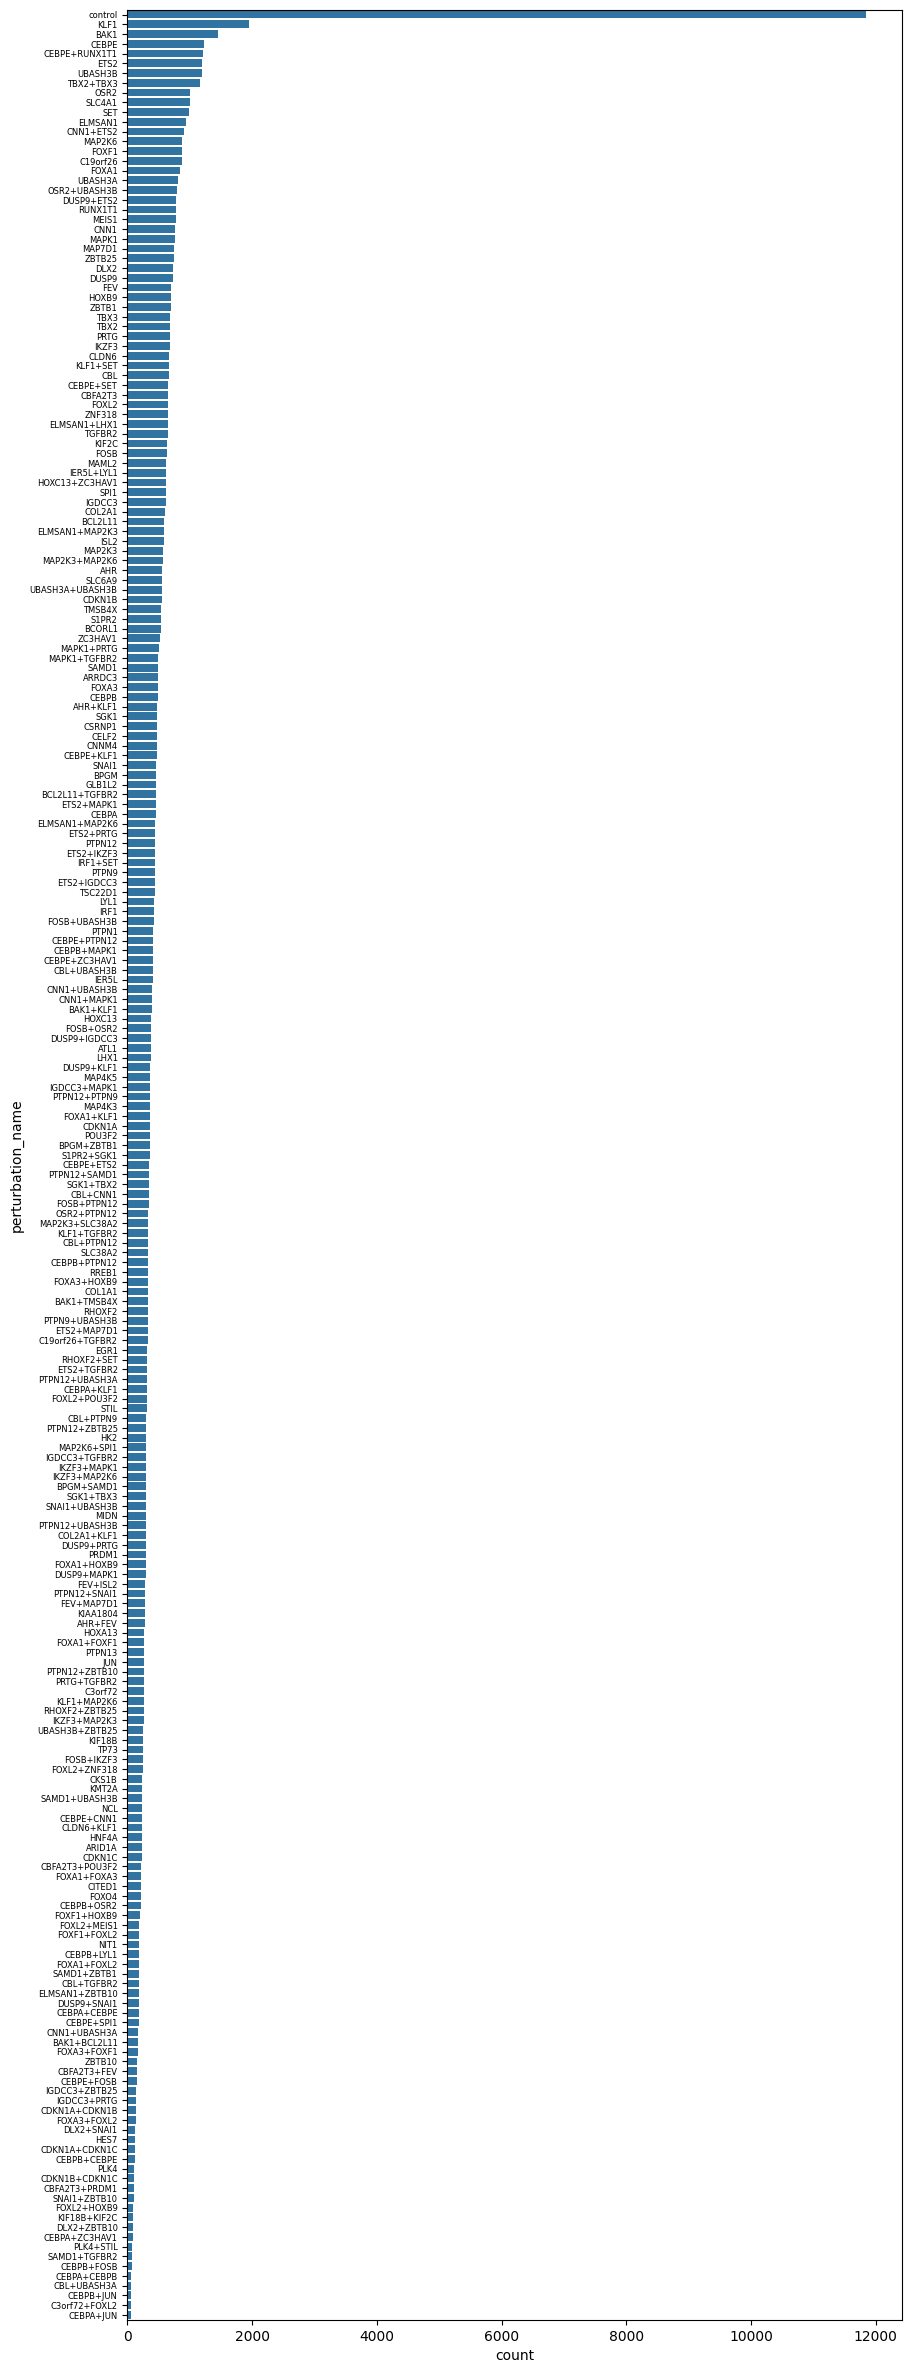

In [21]:
column_to_barplot(adata, "perturbation_name", figsize = (10, 30), fontsize=6)

gene_1
control    11835
CEBPE       5313
ETS2        3632
KLF1        3220
DUSP9       3032
           ...  
FOXO4        215
PLK4         194
NIT1         191
ZBTB10       160
HES7         126
Name: count, Length: 106, dtype: int64

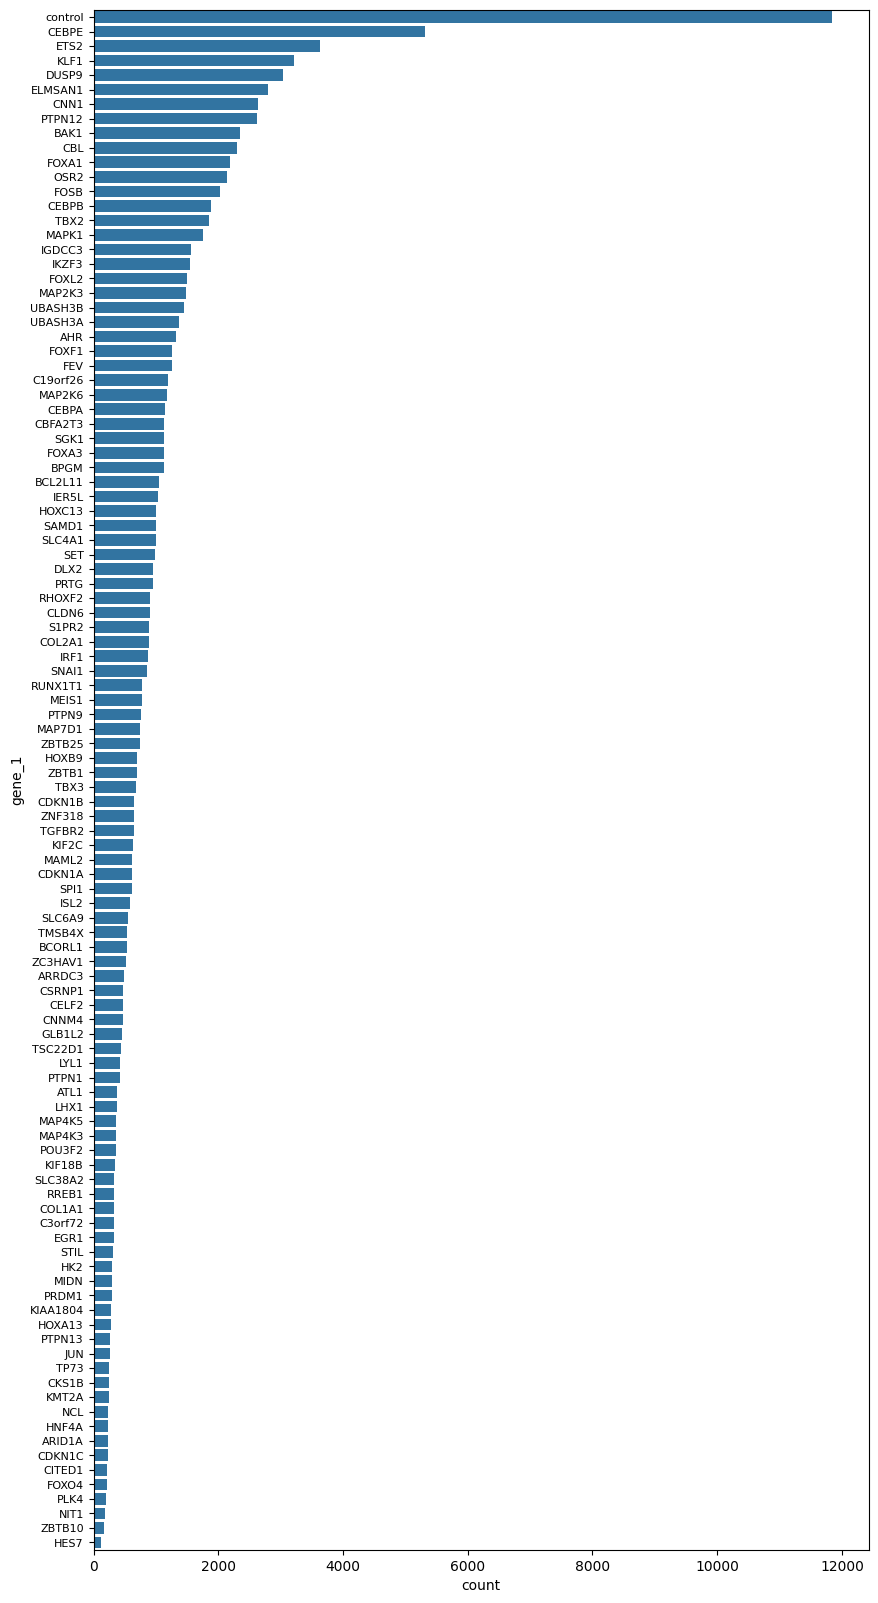

In [22]:
display(adata.obs["gene_1"].value_counts())
column_to_barplot(adata, "gene_1", figsize = (10, 20), fontsize=8)

gene_2
control    69570
UBASH3B     3742
KLF1        2911
TGFBR2      2758
MAPK1       2226
SET         2088
ETS2        2044
PTPN12      1761
MAP2K6      1581
TBX3        1463
PRTG        1381
RUNX1T1     1215
ZC3HAV1     1112
ZBTB25       961
HOXB9        917
MAP2K3       841
IGDCC3       823
LYL1         814
IKZF3        691
PTPN9        669
SAMD1        651
LHX1         645
ZBTB10       636
MAP7D1       601
SNAI1        594
OSR2         593
CNN1         585
FOXL2        571
UBASH3A      552
ZBTB1        548
POU3F2       525
SPI1         481
FOXF1        447
FEV          435
SGK1         356
TBX2         349
SLC38A2      338
TMSB4X       328
CEBPE        293
ISL2         284
ZNF318       245
CDKN1C       232
FOSB         222
FOXA3        216
MEIS1        193
BCL2L11      175
CDKN1B       134
JUN          113
PRDM1        105
KIF2C         95
STIL          81
CEBPB         64
Name: count, dtype: int64

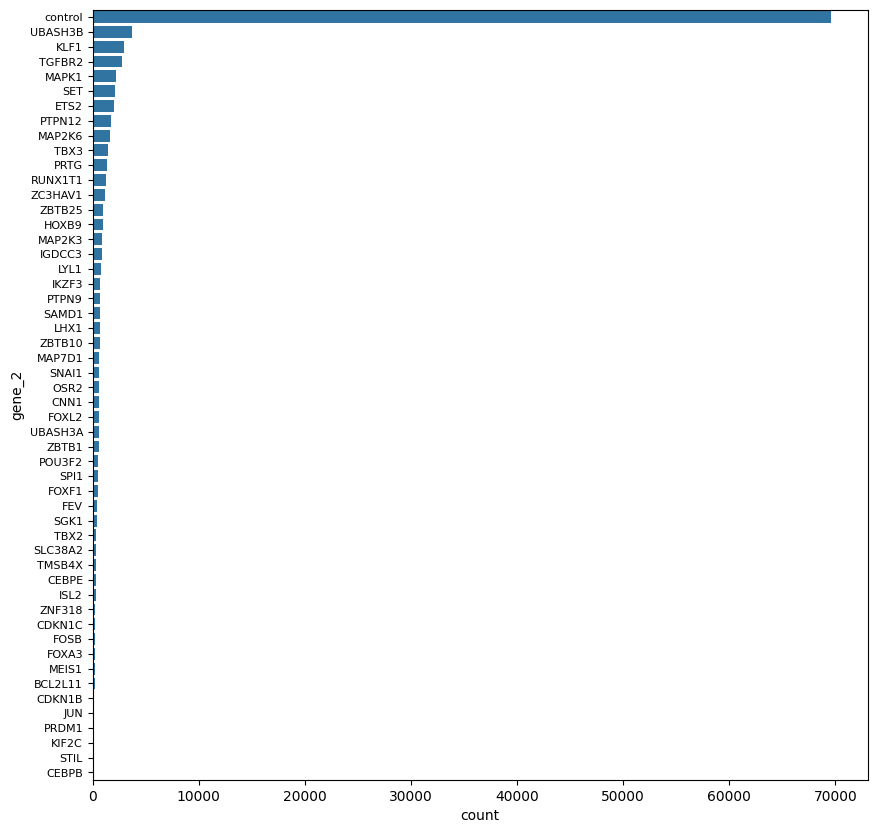

In [23]:
display(adata.obs["gene_2"].value_counts())
column_to_barplot(adata, "gene_2", figsize = (10, 10), fontsize=8)

In [24]:
# basic preprocessing
adata.X = adata.layers["counts"]
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, inplace=True, n_top_genes=2000, subset=True)

In [25]:
# add boolean column that indicates control cells, add cell_line column
adata.obs.loc[:, "control"] = (adata.obs.loc[:, "gene_1"] == "control") & (adata.obs.loc[:, "gene_2"] == "control")
adata.obs["cell_line"] = 'K562'
display(adata.obs)

,guide_identity,read_count,UMI_count,coverage,gemgroup,good_coverage,number_of_cells,guide_AHR,guide_ARID1A,guide_ARRDC3,...,pct_counts_mt,leiden,perturbation_name,perturbation_type,perturbation_value,perturbation_unit,gene_1,gene_2,control,cell_line
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGAAGAAGC-1,NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0,1252,67,18.686567,1,True,2,0,0,0,...,6.835625,10,control,genetic,NaN,NaN,control,control,True,K562
AAACCTGAGGCATGTG-1,TSC22D1_NegCtrl0__TSC22D1_NegCtrl0,2151,104,20.682692,1,True,1,0,0,0,...,7.139676,3,TSC22D1,genetic,NaN,NaN,TSC22D1,control,False,K562
AAACCTGAGGCCCTTG-1,KLF1_MAP2K6__KLF1_MAP2K6,1037,59,17.576271,1,True,1,0,0,0,...,6.664371,7,KLF1+MAP2K6,genetic,NaN,NaN,KLF1,MAP2K6,False,K562
AAACCTGCACGAAGCA-1,NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0,958,39,24.564103,1,True,1,0,0,0,...,7.643963,2,control,genetic,NaN,NaN,control,control,True,K562
AAACCTGCAGACGTAG-1,CEBPE_RUNX1T1__CEBPE_RUNX1T1,244,14,17.428571,1,True,1,0,0,0,...,9.780942,10,CEBPE+RUNX1T1,genetic,NaN,NaN,CEBPE,RUNX1T1,False,K562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCATCAGTACGT-8,FOXA3_NegCtrl0__FOXA3_NegCtrl0,2068,95,21.768421,8,True,1,0,0,0,...,6.097644,3,FOXA3,genetic,NaN,NaN,FOXA3,control,False,K562
TTTGTCATCCACTCCA-8,CELF2_NegCtrl0__CELF2_NegCtrl0,829,33,25.121212,8,True,1,0,0,0,...,5.805128,10,CELF2,genetic,NaN,NaN,CELF2,control,False,K562
TTTGTCATCCCAACGG-8,BCORL1_NegCtrl0__BCORL1_NegCtrl0,136,9,15.111111,8,True,1,0,0,0,...,5.651672,4,BCORL1,genetic,NaN,NaN,BCORL1,control,False,K562


### Important!


We are gonna compare against GEARS with different settings, we need to build different splits. In all of them we rank the perturbations using Sinkhorn Divergence, so better doing it now.

In [26]:
from ott.geometry import costs, pointcloud
from ott.solvers.linear import sinkhorn
from ott.solvers import linear
from ott.tools.sinkhorn_divergence import sinkhorn_divergence

pert_effects = {}
sc.pp.pca(adata)
control_adata = adata[adata.obs.control]

In [27]:
sc.pp.subsample(control_adata, 0.15)

In [28]:
control_adata.n_obs

1775

In [34]:
for c in tqdm(adata.obs.perturbation_name.unique()):
    if "control" in c: # we only want to have combinations of drugs as potential OOD
        continue

    print(
        control_adata.obsm["X_pca"].shape,
        adata[adata.obs["perturbation_name"]==c].obsm["X_pca"].shape
    )
    
    pert_effects[c] = float(
        sinkhorn_divergence(
            pointcloud.PointCloud,
            x=control_adata.obsm["X_pca"],
            y=adata[adata.obs["perturbation_name"]==c].obsm["X_pca"],
            cost_fn=costs.SqEuclidean(),
            epsilon=1e-1,
            scale_cost=1.0,
        ).divergence
    )
    # break

  0%|          | 0/237 [00:00<?, ?it/s]

(1775, 50) (440, 50)


  1%|          | 2/237 [00:01<02:16,  1.73it/s]

(1775, 50) (263, 50)


  1%|▏         | 3/237 [00:02<03:14,  1.20it/s]

(1775, 50) (1215, 50)


  2%|▏         | 4/237 [00:03<04:03,  1.05s/it]

(1775, 50) (624, 50)


  2%|▏         | 5/237 [00:04<04:13,  1.09s/it]

(1775, 50) (1230, 50)


  3%|▎         | 6/237 [00:06<04:40,  1.21s/it]

(1775, 50) (324, 50)


  3%|▎         | 7/237 [00:07<04:36,  1.20s/it]

(1775, 50) (305, 50)


  3%|▎         | 8/237 [00:09<04:59,  1.31s/it]

(1775, 50) (645, 50)


  4%|▍         | 9/237 [00:11<06:47,  1.79s/it]

(1775, 50) (318, 50)


  4%|▍         | 10/237 [00:14<07:41,  2.03s/it]

(1775, 50) (299, 50)


  5%|▍         | 11/237 [00:17<08:22,  2.23s/it]

(1775, 50) (729, 50)


  5%|▌         | 12/237 [00:19<08:53,  2.37s/it]

(1775, 50) (302, 50)


  5%|▌         | 13/237 [00:22<09:06,  2.44s/it]

(1775, 50) (935, 50)


  6%|▌         | 14/237 [00:25<09:35,  2.58s/it]

(1775, 50) (1201, 50)


  6%|▋         | 15/237 [00:28<10:35,  2.86s/it]

(1775, 50) (297, 50)


  7%|▋         | 16/237 [00:31<10:23,  2.82s/it]

(1775, 50) (850, 50)


  7%|▋         | 17/237 [00:34<10:28,  2.86s/it]

(1775, 50) (216, 50)


  8%|▊         | 18/237 [00:37<10:10,  2.79s/it]

(1775, 50) (441, 50)


  8%|▊         | 19/237 [00:39<10:00,  2.76s/it]

(1775, 50) (533, 50)


  8%|▊         | 20/237 [00:42<09:57,  2.76s/it]

(1775, 50) (775, 50)


  9%|▉         | 21/237 [00:45<10:07,  2.81s/it]

(1775, 50) (463, 50)


  9%|▉         | 22/237 [00:48<09:58,  2.78s/it]

(1775, 50) (1954, 50)


 10%|▉         | 23/237 [00:51<10:11,  2.86s/it]

(1775, 50) (338, 50)


 10%|█         | 24/237 [00:54<09:54,  2.79s/it]

(1775, 50) (300, 50)


 11%|█         | 25/237 [00:56<09:45,  2.76s/it]

(1775, 50) (1451, 50)


 11%|█         | 26/237 [00:59<09:58,  2.83s/it]

(1775, 50) (703, 50)


 11%|█▏        | 27/237 [01:02<10:00,  2.86s/it]

(1775, 50) (338, 50)


 12%|█▏        | 28/237 [01:03<08:14,  2.36s/it]

(1775, 50) (379, 50)


 12%|█▏        | 29/237 [01:06<08:36,  2.48s/it]

(1775, 50) (663, 50)


 13%|█▎        | 30/237 [01:09<08:50,  2.56s/it]

(1775, 50) (1201, 50)


 13%|█▎        | 31/237 [01:10<07:32,  2.20s/it]

(1775, 50) (985, 50)


 14%|█▎        | 32/237 [01:13<08:12,  2.40s/it]

(1775, 50) (689, 50)


 14%|█▍        | 33/237 [01:16<08:40,  2.55s/it]

(1775, 50) (375, 50)


 14%|█▍        | 34/237 [01:19<08:44,  2.58s/it]

(1775, 50) (361, 50)


 15%|█▍        | 35/237 [01:22<09:43,  2.89s/it]

(1775, 50) (1164, 50)


 15%|█▌        | 36/237 [01:25<09:54,  2.96s/it]

(1775, 50) (998, 50)


 16%|█▌        | 37/237 [01:28<09:56,  2.98s/it]

(1775, 50) (331, 50)


 16%|█▌        | 38/237 [01:31<09:36,  2.90s/it]

(1775, 50) (649, 50)


 16%|█▋        | 39/237 [01:34<09:32,  2.89s/it]

(1775, 50) (290, 50)


 17%|█▋        | 40/237 [01:37<09:20,  2.85s/it]

(1775, 50) (596, 50)


 17%|█▋        | 41/237 [01:40<09:21,  2.87s/it]

(1775, 50) (739, 50)


 18%|█▊        | 42/237 [01:42<09:15,  2.85s/it]

(1775, 50) (366, 50)


 18%|█▊        | 43/237 [01:45<09:07,  2.82s/it]

(1775, 50) (467, 50)


 19%|█▊        | 44/237 [01:48<09:05,  2.82s/it]

(1775, 50) (557, 50)


 19%|█▉        | 45/237 [01:51<09:10,  2.87s/it]

(1775, 50) (298, 50)


 19%|█▉        | 46/237 [01:54<09:01,  2.83s/it]

(1775, 50) (795, 50)


 20%|█▉        | 47/237 [01:57<09:09,  2.89s/it]

(1775, 50) (730, 50)


 20%|██        | 48/237 [02:00<09:24,  2.98s/it]

(1775, 50) (255, 50)


 21%|██        | 49/237 [02:03<09:18,  2.97s/it]

(1775, 50) (657, 50)


 21%|██        | 50/237 [02:06<09:31,  3.05s/it]

(1775, 50) (126, 50)


 22%|██▏       | 51/237 [02:09<09:20,  3.01s/it]

(1775, 50) (786, 50)


 22%|██▏       | 52/237 [02:12<09:21,  3.04s/it]

(1775, 50) (245, 50)


 22%|██▏       | 53/237 [02:15<09:03,  2.96s/it]

(1775, 50) (657, 50)


 23%|██▎       | 54/237 [02:16<07:33,  2.48s/it]

(1775, 50) (325, 50)


 23%|██▎       | 55/237 [02:19<07:51,  2.59s/it]

(1775, 50) (141, 50)


 24%|██▎       | 56/237 [02:22<08:23,  2.78s/it]

(1775, 50) (558, 50)


 24%|██▍       | 57/237 [02:27<09:53,  3.30s/it]

(1775, 50) (215, 50)


 24%|██▍       | 58/237 [02:30<09:21,  3.13s/it]

(1775, 50) (327, 50)


 25%|██▍       | 59/237 [02:32<09:01,  3.04s/it]

(1775, 50) (613, 50)


 25%|██▌       | 60/237 [02:35<08:54,  3.02s/it]

(1775, 50) (777, 50)


 26%|██▌       | 61/237 [02:39<09:00,  3.07s/it]

(1775, 50) (276, 50)


 26%|██▌       | 62/237 [02:42<09:37,  3.30s/it]

(1775, 50) (540, 50)


 27%|██▋       | 63/237 [02:46<09:39,  3.33s/it]

(1775, 50) (359, 50)


 27%|██▋       | 64/237 [02:49<09:13,  3.20s/it]

(1775, 50) (623, 50)


 27%|██▋       | 65/237 [02:52<09:00,  3.14s/it]

(1775, 50) (765, 50)


 28%|██▊       | 66/237 [02:55<08:43,  3.06s/it]

(1775, 50) (366, 50)


 28%|██▊       | 67/237 [02:56<07:06,  2.51s/it]

(1775, 50) (475, 50)


 29%|██▊       | 68/237 [02:59<07:23,  2.62s/it]

(1775, 50) (54, 50)


 29%|██▉       | 69/237 [03:01<07:23,  2.64s/it]

(1775, 50) (578, 50)


 30%|██▉       | 70/237 [03:04<07:31,  2.70s/it]

(1775, 50) (362, 50)


 30%|██▉       | 71/237 [03:07<07:34,  2.74s/it]

(1775, 50) (496, 50)


 30%|███       | 72/237 [03:10<07:40,  2.79s/it]

(1775, 50) (328, 50)


 31%|███       | 73/237 [03:13<07:34,  2.77s/it]

(1775, 50) (409, 50)


 31%|███       | 74/237 [03:16<07:39,  2.82s/it]

(1775, 50) (360, 50)


 32%|███▏      | 75/237 [03:18<07:35,  2.81s/it]

(1775, 50) (554, 50)


 32%|███▏      | 76/237 [03:21<07:38,  2.85s/it]

(1775, 50) (570, 50)


 32%|███▏      | 77/237 [03:24<07:40,  2.88s/it]

(1775, 50) (499, 50)


 33%|███▎      | 78/237 [03:27<07:31,  2.84s/it]

(1775, 50) (417, 50)


 33%|███▎      | 79/237 [03:30<07:31,  2.86s/it]

(1775, 50) (689, 50)


 34%|███▍      | 80/237 [03:31<06:22,  2.44s/it]

(1775, 50) (404, 50)


 34%|███▍      | 81/237 [03:34<06:38,  2.55s/it]

(1775, 50) (458, 50)


 35%|███▍      | 82/237 [03:37<06:52,  2.66s/it]

(1775, 50) (445, 50)


 35%|███▌      | 83/237 [03:40<06:55,  2.70s/it]

(1775, 50) (248, 50)


 35%|███▌      | 84/237 [03:43<06:56,  2.72s/it]

(1775, 50) (751, 50)


 36%|███▌      | 85/237 [03:47<08:00,  3.16s/it]

(1775, 50) (260, 50)


 36%|███▋      | 86/237 [03:50<07:40,  3.05s/it]

(1775, 50) (630, 50)


 37%|███▋      | 87/237 [03:53<07:35,  3.04s/it]

(1775, 50) (763, 50)


 37%|███▋      | 88/237 [03:56<07:32,  3.04s/it]

(1775, 50) (297, 50)


 38%|███▊      | 89/237 [03:57<06:09,  2.49s/it]

(1775, 50) (872, 50)


 38%|███▊      | 90/237 [04:00<06:34,  2.69s/it]

(1775, 50) (427, 50)


 38%|███▊      | 91/237 [04:03<06:38,  2.73s/it]

(1775, 50) (297, 50)


 39%|███▉      | 92/237 [04:04<05:26,  2.25s/it]

(1775, 50) (300, 50)


 39%|███▉      | 93/237 [04:05<04:43,  1.97s/it]

(1775, 50) (680, 50)


 40%|███▉      | 94/237 [04:08<05:24,  2.27s/it]

(1775, 50) (309, 50)


 40%|████      | 95/237 [04:11<05:45,  2.43s/it]

(1775, 50) (701, 50)


 41%|████      | 96/237 [04:14<06:10,  2.63s/it]

(1775, 50) (384, 50)


 41%|████      | 97/237 [04:17<06:13,  2.67s/it]

(1775, 50) (301, 50)


 41%|████▏     | 98/237 [04:20<06:16,  2.71s/it]

(1775, 50) (445, 50)


 42%|████▏     | 99/237 [04:21<05:13,  2.27s/it]

(1775, 50) (241, 50)


 42%|████▏     | 100/237 [04:24<05:32,  2.43s/it]

(1775, 50) (670, 50)


 43%|████▎     | 101/237 [04:27<05:56,  2.62s/it]

(1775, 50) (493, 50)


 43%|████▎     | 102/237 [04:30<06:08,  2.73s/it]

(1775, 50) (95, 50)


 43%|████▎     | 103/237 [04:33<06:04,  2.72s/it]

(1775, 50) (460, 50)


 44%|████▍     | 104/237 [04:35<06:06,  2.76s/it]

(1775, 50) (481, 50)


 44%|████▍     | 105/237 [04:38<06:13,  2.83s/it]

(1775, 50) (328, 50)


 45%|████▍     | 106/237 [04:40<05:08,  2.35s/it]

(1775, 50) (311, 50)


 45%|████▌     | 107/237 [04:43<05:27,  2.52s/it]

(1775, 50) (873, 50)


 46%|████▌     | 108/237 [04:53<10:12,  4.75s/it]

(1775, 50) (691, 50)


 46%|████▌     | 109/237 [04:56<09:09,  4.30s/it]

(1775, 50) (277, 50)


 46%|████▋     | 110/237 [04:59<08:06,  3.83s/it]

(1775, 50) (684, 50)


 47%|████▋     | 111/237 [05:02<07:33,  3.60s/it]

(1775, 50) (113, 50)


 47%|████▋     | 112/237 [05:04<06:58,  3.35s/it]

(1775, 50) (464, 50)


 48%|████▊     | 113/237 [05:07<06:36,  3.19s/it]

(1775, 50) (494, 50)


 48%|████▊     | 114/237 [05:10<06:24,  3.13s/it]

(1775, 50) (904, 50)


 49%|████▊     | 115/237 [05:13<06:19,  3.11s/it]

(1775, 50) (264, 50)


 49%|████▉     | 116/237 [05:16<06:05,  3.02s/it]

(1775, 50) (582, 50)


 49%|████▉     | 117/237 [05:19<05:59,  3.00s/it]

(1775, 50) (398, 50)


 50%|████▉     | 118/237 [05:27<08:50,  4.46s/it]

(1775, 50) (193, 50)


 50%|█████     | 119/237 [05:30<07:45,  3.94s/it]

(1775, 50) (432, 50)


 51%|█████     | 120/237 [05:33<07:05,  3.63s/it]

(1775, 50) (878, 50)


 51%|█████     | 121/237 [05:37<07:17,  3.77s/it]

(1775, 50) (481, 50)


 51%|█████▏    | 122/237 [05:38<05:50,  3.05s/it]

(1775, 50) (549, 50)


 52%|█████▏    | 123/237 [05:41<05:43,  3.02s/it]

(1775, 50) (496, 50)


 52%|█████▏    | 124/237 [05:42<04:41,  2.49s/it]

(1775, 50) (652, 50)


 53%|█████▎    | 125/237 [05:45<04:56,  2.65s/it]

(1775, 50) (329, 50)


 53%|█████▎    | 126/237 [05:48<05:02,  2.72s/it]

(1775, 50) (444, 50)


 54%|█████▎    | 127/237 [05:52<05:29,  3.00s/it]

(1775, 50) (191, 50)


 54%|█████▍    | 128/237 [05:55<05:23,  2.96s/it]

(1775, 50) (151, 50)


 54%|█████▍    | 129/237 [05:57<05:17,  2.94s/it]

(1775, 50) (613, 50)


 55%|█████▍    | 130/237 [05:59<04:23,  2.47s/it]

(1775, 50) (364, 50)


 55%|█████▌    | 131/237 [06:02<04:38,  2.63s/it]

(1775, 50) (1002, 50)


 56%|█████▌    | 132/237 [06:05<05:07,  2.92s/it]

(1775, 50) (236, 50)


 56%|█████▌    | 133/237 [06:08<05:03,  2.91s/it]

(1775, 50) (71, 50)


 57%|█████▋    | 134/237 [06:11<04:55,  2.86s/it]

(1775, 50) (354, 50)


 57%|█████▋    | 135/237 [06:14<04:52,  2.87s/it]

(1775, 50) (666, 50)


 57%|█████▋    | 136/237 [06:17<05:00,  2.98s/it]

(1775, 50) (283, 50)


 58%|█████▊    | 137/237 [06:20<05:02,  3.02s/it]

(1775, 50) (241, 50)


 58%|█████▊    | 138/237 [06:22<04:06,  2.49s/it]

(1775, 50) (175, 50)


 59%|█████▊    | 139/237 [06:25<04:17,  2.63s/it]

(1775, 50) (177, 50)


 59%|█████▉    | 140/237 [06:28<04:25,  2.73s/it]

(1775, 50) (448, 50)


 59%|█████▉    | 141/237 [06:31<04:31,  2.83s/it]

(1775, 50) (579, 50)


 60%|█████▉    | 142/237 [06:34<04:40,  2.95s/it]

(1775, 50) (301, 50)


 60%|██████    | 143/237 [06:35<03:48,  2.43s/it]

(1775, 50) (190, 50)


 61%|██████    | 144/237 [06:38<04:00,  2.58s/it]

(1775, 50) (542, 50)


 61%|██████    | 145/237 [06:41<04:14,  2.76s/it]

(1775, 50) (634, 50)


 62%|██████▏   | 146/237 [06:44<04:23,  2.89s/it]

(1775, 50) (64, 50)


 62%|██████▏   | 147/237 [06:47<04:16,  2.85s/it]

(1775, 50) (444, 50)


 62%|██████▏   | 148/237 [06:48<03:29,  2.35s/it]

(1775, 50) (581, 50)


 63%|██████▎   | 149/237 [06:51<03:48,  2.60s/it]

(1775, 50) (477, 50)


 63%|██████▎   | 150/237 [06:54<03:56,  2.72s/it]

(1775, 50) (392, 50)


 64%|██████▎   | 151/237 [06:57<03:59,  2.78s/it]

(1775, 50) (231, 50)


 64%|██████▍   | 152/237 [07:00<04:03,  2.86s/it]

(1775, 50) (179, 50)


 65%|██████▍   | 153/237 [07:04<04:05,  2.92s/it]

(1775, 50) (470, 50)


 65%|██████▍   | 154/237 [07:07<04:04,  2.95s/it]

(1775, 50) (190, 50)


 65%|██████▌   | 155/237 [07:08<03:21,  2.45s/it]

(1775, 50) (817, 50)


 66%|██████▌   | 156/237 [07:11<03:34,  2.65s/it]

(1775, 50) (237, 50)


 66%|██████▌   | 157/237 [07:14<03:42,  2.79s/it]

(1775, 50) (237, 50)


 67%|██████▋   | 158/237 [07:17<03:46,  2.86s/it]

(1775, 50) (617, 50)


 67%|██████▋   | 159/237 [07:20<03:50,  2.95s/it]

(1775, 50) (191, 50)


 68%|██████▊   | 160/237 [07:21<03:06,  2.42s/it]

(1775, 50) (348, 50)


 68%|██████▊   | 161/237 [07:25<03:25,  2.70s/it]

(1775, 50) (265, 50)


 68%|██████▊   | 162/237 [07:28<03:37,  2.90s/it]

(1775, 50) (406, 50)


 69%|██████▉   | 163/237 [07:31<03:37,  2.94s/it]

(1775, 50) (199, 50)


 69%|██████▉   | 164/237 [07:34<03:40,  3.03s/it]

(1775, 50) (299, 50)


 70%|██████▉   | 165/237 [07:37<03:20,  2.78s/it]

(1775, 50) (401, 50)


 70%|███████   | 166/237 [07:40<03:25,  2.89s/it]

(1775, 50) (331, 50)


 70%|███████   | 167/237 [07:41<02:50,  2.43s/it]

(1775, 50) (515, 50)


 71%|███████   | 168/237 [07:45<03:14,  2.81s/it]

(1775, 50) (349, 50)


 71%|███████▏  | 169/237 [07:48<03:17,  2.91s/it]

(1775, 50) (187, 50)


 72%|███████▏  | 170/237 [07:51<03:15,  2.92s/it]

(1775, 50) (382, 50)


 72%|███████▏  | 171/237 [07:54<03:13,  2.93s/it]

(1775, 50) (412, 50)


 73%|███████▎  | 172/237 [07:57<03:14,  2.99s/it]

(1775, 50) (444, 50)


 73%|███████▎  | 173/237 [07:58<02:37,  2.46s/it]

(1775, 50) (425, 50)


 73%|███████▎  | 174/237 [08:01<02:46,  2.64s/it]

(1775, 50) (459, 50)


 74%|███████▍  | 175/237 [08:04<02:51,  2.77s/it]

(1775, 50) (306, 50)


 74%|███████▍  | 176/237 [08:07<02:53,  2.85s/it]

(1775, 50) (382, 50)


 75%|███████▍  | 177/237 [08:09<02:22,  2.37s/it]

(1775, 50) (487, 50)


 75%|███████▌  | 178/237 [08:12<02:32,  2.58s/it]

(1775, 50) (333, 50)


 76%|███████▌  | 179/237 [08:15<02:36,  2.70s/it]

(1775, 50) (211, 50)


 76%|███████▌  | 180/237 [08:18<02:37,  2.77s/it]

(1775, 50) (356, 50)


 76%|███████▋  | 181/237 [08:21<02:40,  2.87s/it]

(1775, 50) (366, 50)


 77%|███████▋  | 182/237 [08:22<02:11,  2.39s/it]

(1775, 50) (240, 50)


 77%|███████▋  | 183/237 [08:25<02:17,  2.55s/it]

(1775, 50) (644, 50)


 78%|███████▊  | 184/237 [08:28<02:23,  2.71s/it]

(1775, 50) (284, 50)


 78%|███████▊  | 185/237 [08:31<02:25,  2.80s/it]

(1775, 50) (264, 50)


 78%|███████▊  | 186/237 [08:32<02:00,  2.36s/it]

(1775, 50) (265, 50)


 79%|███████▉  | 187/237 [08:34<01:41,  2.03s/it]

(1775, 50) (236, 50)


 79%|███████▉  | 188/237 [08:35<01:28,  1.80s/it]

(1775, 50) (216, 50)


 80%|███████▉  | 189/237 [08:37<01:32,  1.92s/it]

(1775, 50) (293, 50)


 80%|████████  | 190/237 [08:40<01:46,  2.26s/it]

(1775, 50) (89, 50)


 81%|████████  | 191/237 [08:43<01:53,  2.46s/it]

(1775, 50) (72, 50)


 81%|████████  | 192/237 [08:46<01:56,  2.60s/it]

(1775, 50) (160, 50)


 81%|████████▏ | 193/237 [08:49<01:57,  2.68s/it]

(1775, 50) (179, 50)


 82%|████████▏ | 194/237 [08:50<01:36,  2.24s/it]

(1775, 50) (270, 50)


 82%|████████▏ | 195/237 [08:53<01:43,  2.47s/it]

(1775, 50) (414, 50)


 83%|████████▎ | 196/237 [08:56<01:49,  2.67s/it]

(1775, 50) (107, 50)


 83%|████████▎ | 197/237 [08:59<01:50,  2.77s/it]

(1775, 50) (192, 50)


 84%|████████▎ | 198/237 [09:02<01:47,  2.76s/it]

(1775, 50) (276, 50)


 84%|████████▍ | 199/237 [09:03<01:28,  2.34s/it]

(1775, 50) (337, 50)


 84%|████████▍ | 200/237 [09:06<01:35,  2.57s/it]

(1775, 50) (134, 50)


 85%|████████▍ | 201/237 [09:09<01:37,  2.70s/it]

(1775, 50) (159, 50)


 85%|████████▌ | 202/237 [09:12<01:37,  2.78s/it]

(1775, 50) (332, 50)


 86%|████████▌ | 203/237 [09:15<01:37,  2.86s/it]

(1775, 50) (273, 50)


 86%|████████▌ | 204/237 [09:18<01:36,  2.93s/it]

(1775, 50) (303, 50)


 86%|████████▋ | 205/237 [09:21<01:34,  2.94s/it]

(1775, 50) (114, 50)


 87%|████████▋ | 206/237 [09:27<01:52,  3.64s/it]

(1775, 50) (129, 50)


 87%|████████▋ | 207/237 [09:30<01:43,  3.45s/it]

(1775, 50) (466, 50)


 88%|████████▊ | 208/237 [09:33<01:36,  3.34s/it]

(1775, 50) (64, 50)


 88%|████████▊ | 209/237 [09:34<01:15,  2.70s/it]

(1775, 50) (262, 50)


 89%|████████▊ | 210/237 [09:37<01:15,  2.80s/it]

(1775, 50) (215, 50)


 89%|████████▉ | 211/237 [09:39<01:08,  2.62s/it]

(1775, 50) (321, 50)


 89%|████████▉ | 212/237 [09:42<01:09,  2.80s/it]

(1775, 50) (311, 50)


 90%|████████▉ | 213/237 [09:44<00:58,  2.44s/it]

(1775, 50) (247, 50)


 90%|█████████ | 214/237 [09:47<01:01,  2.66s/it]

(1775, 50) (296, 50)


 91%|█████████ | 215/237 [09:50<01:02,  2.83s/it]

(1775, 50) (345, 50)


 91%|█████████ | 216/237 [09:54<01:01,  2.91s/it]

(1775, 50) (351, 50)


 92%|█████████▏| 217/237 [09:57<01:00,  3.01s/it]

(1775, 50) (303, 50)


 92%|█████████▏| 218/237 [09:58<00:46,  2.47s/it]

(1775, 50) (96, 50)


 92%|█████████▏| 219/237 [10:01<00:46,  2.56s/it]

(1775, 50) (321, 50)


 93%|█████████▎| 220/237 [10:02<00:36,  2.17s/it]

(1775, 50) (358, 50)


 93%|█████████▎| 221/237 [10:05<00:38,  2.42s/it]

(1775, 50) (59, 50)


 94%|█████████▎| 222/237 [10:08<00:38,  2.57s/it]

(1775, 50) (100, 50)


 94%|█████████▍| 223/237 [10:11<00:37,  2.70s/it]

(1775, 50) (323, 50)


E1015 16:27:54.582181 3072575 hlo_lexer.cc:443] Failed to parse int literal: 4683564992900387549724
 95%|█████████▍| 224/237 [10:14<00:36,  2.84s/it]

(1775, 50) (105, 50)


 95%|█████████▍| 225/237 [10:17<00:34,  2.89s/it]

(1775, 50) (175, 50)


 95%|█████████▌| 226/237 [10:18<00:26,  2.41s/it]

(1775, 50) (182, 50)


 96%|█████████▌| 227/237 [10:21<00:25,  2.58s/it]

(1775, 50) (130, 50)


 96%|█████████▌| 228/237 [10:24<00:24,  2.73s/it]

(1775, 50) (86, 50)


 97%|█████████▋| 229/237 [10:27<00:22,  2.79s/it]

(1775, 50) (272, 50)


 97%|█████████▋| 230/237 [10:30<00:19,  2.84s/it]

(1775, 50) (253, 50)


 97%|█████████▋| 231/237 [10:33<00:17,  2.88s/it]

(1775, 50) (140, 50)


 98%|█████████▊| 232/237 [10:36<00:14,  2.91s/it]

(1775, 50) (125, 50)


 98%|█████████▊| 233/237 [10:39<00:11,  2.93s/it]

(1775, 50) (81, 50)


 99%|█████████▊| 234/237 [10:42<00:08,  2.94s/it]

(1775, 50) (182, 50)


 99%|█████████▉| 235/237 [10:43<00:04,  2.42s/it]

(1775, 50) (229, 50)


100%|█████████▉| 236/237 [10:46<00:02,  2.60s/it]

(1775, 50) (59, 50)


100%|██████████| 237/237 [10:48<00:00,  2.73s/it]


In [39]:
pd.to_pickle(pert_effects, "./pert_effects.pkl")

In [29]:
pert_effects = pd.read_pickle("./pert_effects.pkl")

In [30]:
df_effects = pd.DataFrame({"conditions": pert_effects.keys(), "sinkhorn_div": pert_effects.values()})
df_effects = df_effects.sort_values("sinkhorn_div")
display(df_effects)

,conditions,sinkhorn_div
24,BAK1,24.722202
115,BCL2L11,26.296936
3,MAML2,26.538143
182,TGFBR2,26.719774
59,RUNX1T1,26.752579
...,...,...
151,CEBPA+CEBPE,157.644623
227,CEBPA+ZC3HAV1,159.242584
207,CEBPA+CEBPB,173.225815
80,CEBPA,176.338715


### First split: OOD will be only combinations of seen genes.

#### OOD evaluation are always on combinations of two genes that have been knocked-in. We can distinguish three cases (with increasing difficulty):
- The training set contains samples where one of the two genes in the OOD combination has been knocked in. The training set does not contain samples where both genes in the OOD combination have been knocked out jointly.

In [31]:
gene1 = adata.obs.gene_1.unique()
gene2 = adata.obs.gene_2.unique()

In [32]:
# single knockout
singleton = adata[adata.obs.gene_2 == 'control'].obs.gene_1.unique()

In [33]:
# double knockout
combinations = np.concatenate(
    (
        adata[adata.obs.gene_2 != 'control'].obs.gene_1.unique(), 
        adata[adata.obs.gene_2 != 'control'].obs.gene_2.unique(),
    )
)

In [55]:
# eligible contains all genes that have been knocked out either singly or jointly
elegible = set(singleton).intersection(set(combinations))
print(f"{len(elegible)} genes out of {len(set(singleton))} singletons appear in combinations")
# eligible_combinations contains gene pairs for which knockouts have been observed either singly or jointly
elegible_combinations = adata[(adata.obs.gene_1.isin(elegible)) & (adata.obs.gene_2.isin(elegible))]
elegible_combinations

73 genes out of 106 singletons appear in combinations


View of AnnData object with n_obs × n_vars = 41685 × 2000
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF

In [58]:
# Double check that the selected combinations appear as singletons
assert set(np.intersect1d(elegible_combinations.obs.gene_1, singleton)) == \
       set(elegible_combinations.obs.gene_1)
print(len(set(elegible_combinations.obs.gene_1.unique())))

49


In [59]:
assert set(np.intersect1d(elegible_combinations.obs.gene_2, elegible_combinations.obs.gene_2)) == \
       set(elegible_combinations.obs.gene_2)
print(len(set(elegible_combinations.obs.gene_2.unique())))

51


In [60]:
elegible_combinations_pert = elegible_combinations.obs.perturbation_name.unique()

### Rank combinations according to Sinkhorn divergence to choose them.
Notice that we need to add control to them to compute the Sinkhorn divergence from control.

In [38]:
elegible_combinations_pert

['KLF1+MAP2K6', 'CEBPE+RUNX1T1', 'ETS2+MAP7D1', 'CBL+PTPN9', 'ELMSAN1+LHX1', ..., 'IGDCC3+PRTG', 'CDKN1A+CDKN1C', 'PLK4+STIL', 'ELMSAN1+ZBTB10', 'C3orf72+FOXL2']
Length: 131
Categories (131, object): ['AHR+FEV', 'AHR+KLF1', 'BAK1+BCL2L11', 'BAK1+KLF1', ..., 'SNAI1+ZBTB10', 'TBX2+TBX3', 'UBASH3A+UBASH3B', 'UBASH3B+ZBTB25']

In [160]:
df_effects

,conditions,sinkhorn_div
24,BAK1,24.722202
115,BCL2L11,26.296936
3,MAML2,26.538143
182,TGFBR2,26.719774
59,RUNX1T1,26.752579
...,...,...
151,CEBPA+CEBPE,157.644623
227,CEBPA+ZC3HAV1,159.242584
207,CEBPA+CEBPB,173.225815
80,CEBPA,176.338715


In [39]:
all_seen_genes = df_effects[df_effects.conditions.isin(elegible_combinations_pert)]

In [40]:
all_seen_genes

,conditions,sinkhorn_div
75,MAP2K3+MAP2K6,28.911852
137,BAK1+BCL2L11,29.296669
102,BCL2L11+TGFBR2,29.386816
71,BAK1+TMSB4X,30.026728
26,MAP2K3+SLC38A2,30.220001
...,...,...
192,CEBPE+SPI1,153.294083
151,CEBPA+CEBPE,157.644623
227,CEBPA+ZC3HAV1,159.242584
207,CEBPA+CEBPB,173.225815


In [165]:
def create_train_test_splits(
    df: pd.DataFrame, 
    num_splits: int,
    stratify_by: str = "sinkhorn_div",
    show: bool = True,
):
    num_classes = int(np.ceil(len(df) / num_splits))
    num_samples_per_class = int(np.ceil(len(df) / num_classes))
    classes = np.arange(0, num_classes).repeat(num_samples_per_class)[:len(df)]
    cv_splitter = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=2024)
    cv_split_idcs = list(cv_splitter.split(np.arange(df.shape[0]), classes))

    cv_splits = []
    df = df.sort_values(by=stratify_by)
    for split_i, split in enumerate(cv_split_idcs):
        train_idcs, test_idcs = split
        cv_splits.append([df.iloc[train_idcs], df.iloc[test_idcs]])

    if show:
        fig, ax = plt.subplots(1, num_splits, figsize=(10, 2))
        for split_i, split in enumerate(cv_split_idcs):
            train_idcs, test_idcs = split
            train_set = df.iloc[train_idcs]
            test_set = df.iloc[test_idcs]
            ax[split_i].hist(train_set.loc[:, stratify_by].values, bins=15, density=True)
            ax[split_i].hist(test_set.loc[:, stratify_by].values, bins=15, density=True, alpha=0.5)
            ax[split_i].set_xlabel(stratify_by)
            ax[split_i].set_ylabel("frequency")
            ax[split_i].set_title(f"#train: {len(train_set)}, #test: {len(test_set)}")
            
        plt.tight_layout()
        plt.show()
    
    return cv_splits

/home/haicu/soeren.becker/miniconda3/envs/env_cfp/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


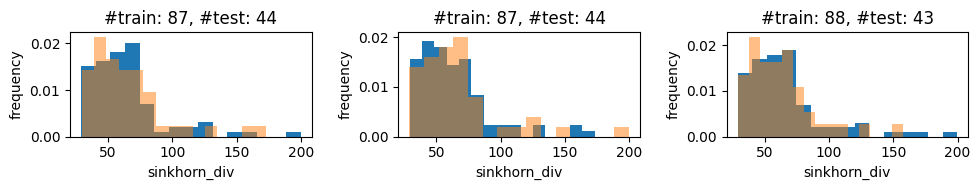

In [166]:
cv_splits = create_train_test_splits(all_seen_genes, 3)

# doublecheck that there is not overlap between train and test conditions
for split in cv_splits:
    train_set, test_set = split
    assert len(np.intersect1d(train_set.conditions, test_set.conditions)) == 0

In [139]:
adata.obs["ood"] = adata.obs.perturbation_name.apply(
    lambda x: x in test_set.conditions.values else "not ood", 
    axis=1
)

In [141]:
adata.obs["is_ood"] = adata.obs.apply(lambda x: x["perturbation_name"] in test_set.conditions, axis=1)
adata.obs["ood"] = adata.obs["ood"].astype("category")

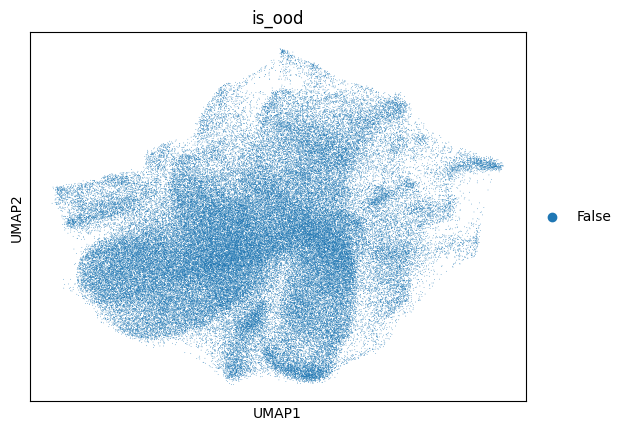

In [142]:
sc.pl.umap(adata, color="is_ood")

In [144]:
adata.obs["is_ood"].any()

False

In [148]:
adata.obs["perturbation_name"].values

['control', 'TSC22D1', 'KLF1+MAP2K6', 'control', 'CEBPE+RUNX1T1', ..., 'FOXA3', 'CELF2', 'BCORL1', 'PTPN12+ZBTB10', 'MAP4K3']
Length: 111255
Categories (237, object): ['AHR', 'AHR+FEV', 'AHR+KLF1', 'ARID1A', ..., 'ZBTB25', 'ZC3HAV1', 'ZNF318', 'control']

array(['BAK1+BCL2L11', 'MAP2K3+SLC38A2', 'OSR2+PTPN12', 'ETS2+TGFBR2',
       'ELMSAN1+MAP2K3', 'ETS2+IGDCC3', 'BAK1+KLF1', 'MAPK1+PRTG',
       'ELMSAN1+LHX1', 'ETS2+PRTG', 'KLF1+MAP2K6', 'CEBPE+SET',
       'IGDCC3+TGFBR2', 'CEBPE+RUNX1T1', 'BPGM+ZBTB1', 'PRTG+TGFBR2',
       'BPGM+SAMD1', 'COL2A1+KLF1', 'IER5L+LYL1', 'CDKN1A+CDKN1B',
       'SGK1+TBX2', 'CDKN1A+CDKN1C', 'PTPN12+ZBTB25', 'PTPN12+UBASH3B',
       'FOXA1+FOXA3', 'FOXF1+HOXB9', 'CBL+UBASH3A', 'S1PR2+SGK1',
       'SAMD1+ZBTB1', 'IGDCC3+ZBTB25', 'CLDN6+KLF1', 'FOXA1+HOXB9',
       'DUSP9+KLF1', 'FOXF1+FOXL2', 'DUSP9+PRTG', 'CNN1+UBASH3B',
       'FOXA3+FOXL2', 'ETS2+IKZF3', 'DUSP9+SNAI1', 'AHR+FEV',
       'DLX2+ZBTB10', 'CEBPB+FOSB', 'CEBPA+CEBPE'], dtype=object)

In [153]:
np.isin(
    adata.obs["perturbation_name"].values,
    test_set.conditions.values,
).any()

True